In [31]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [32]:
# log python version
import sys
print(sys.version)

3.12.3 (main, Apr  9 2024, 08:09:14) [Clang 15.0.0 (clang-1500.1.0.2.5)]


In [33]:
from training import naive_approach
from networks.regression_transformer import RegressionTransformerConfig, RegressionTransformer
from data.neural_field_datasets import DWSNetsDataset, MnistNeFDataset, FlattenTransform, MinMaxTransform

import os
import torch
import torchinfo

/home/luca/.cache/pypoetry/virtualenvs/adl4cv-OvNqwVNf-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
torch.cuda.is_available()

False

In [35]:
# Dataloading
dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root_dwsnet = os.path.join(dir_path, "adl4cv", "datasets", "DWSNets", "mnist-inrs")
data_root_ours = os.path.join(dir_path, "adl4cv", "datasets", "mnist-nerfs")

class FlattenMinMaxTransform(torch.nn.Module):
  def __init__(self, min_max: tuple = None):
    super().__init__()
    self.flatten = FlattenTransform()
    if min_max:
      self.minmax = MinMaxTransform(*min_max)
    else:
      self.minmax = MinMaxTransform()

  def forward(self, x, y):
    x, _ = self.flatten(x, y)
    x, _ = self.minmax(x, y)
    return x, y


dataset = DWSNetsDataset(data_root_dwsnet, transform=FlattenMinMaxTransform())
dataset_wo_min_max = DWSNetsDataset(data_root_dwsnet, transform=FlattenTransform())
dataset_no_transform = DWSNetsDataset(data_root_dwsnet)

dataset_wo_min_max = MnistNeFDataset(data_root_ours, type="pretrained", transform=FlattenTransform())
min_ours, max_ours = dataset_wo_min_max.min_max()
dataset = MnistNeFDataset(data_root_ours, type="pretrained", transform=FlattenMinMaxTransform((min_ours, max_ours)))
dataset_no_transform = MnistNeFDataset(data_root_ours, type="pretrained")

In [36]:
# Config Training
config = naive_approach.Config()
config.learning_rate=5e-4
config.max_iters = 14000
config.weight_decay=0
config.decay_lr=True
config.lr_decay_iters=14000
config.warmup_iters=0.1*config.max_iters
config.batch_size = 1
config.detailed_folder = "training_sample_0"

# Config Transforemer
model_config = RegressionTransformerConfig(n_embd=32, block_size=len(dataset[0][0]) - 1, n_head=8, n_layer=16)

In [37]:
# take first n samples that have label == 1 (where label is second entry of dataset object)
n = 1
samples = [(i, dataset[i][0]) for i in range(len(dataset)) if dataset[i][1] == 5][:n]


def get_batch(split: str):
    # let's get a batch with the single element
    # y should be the same shifted by 1
    ix = torch.zeros(config.batch_size, dtype=torch.int)
    #torch.randint(torch.numel(flattened) - model_config.block_size, (config.batch_size,))

    # randomly select a sample (0...n-1)
    split_start = 0 if split == "train" else int(0.8 * n)
    split_end = int(0.8 * n) if split == "train" else n

    sample = samples[torch.randint(split_start, split_end, (1,))][1]

    x = torch.stack(
        [sample[i : i + model_config.block_size] for i in ix]
    )
    y = torch.stack(
        [sample[i + 1 : i + 1 + model_config.block_size] for i in ix]
    )

    # x and y have to be (1, *, 1)
    x = x.unsqueeze(-1).to(config.device)
    y = y.unsqueeze(-1).to(config.device)
    return x, y

In [39]:
# Prepeare model parameters and train
naive_approach.train(get_batch, config, model_config)

Initializing a new model from scratch
num decayed parameter tensors: 35, with 34,080 parameters
num non-decayed parameter tensors: 67, with 1,712 parameters
using fused AdamW: False


/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


iter,▁
lr,▁
mfu,▁
train/loss,▁
val/loss,▁
iter,0
lr,0.0
mfu,-100.0
train/loss,0.54228
val/loss,0.54228


step 0: train loss 0.6144, val loss 0.6144
saving checkpoint to models
step 100: train loss 0.3856, val loss 0.3856
saving checkpoint to models
saving checkpoint to models
step 200: train loss 0.1506, val loss 0.1506
saving checkpoint to models
saving checkpoint to models
step 300: train loss 0.0496, val loss 0.0496
saving checkpoint to models
saving checkpoint to models
step 400: train loss 0.0415, val loss 0.0415
saving checkpoint to models
saving checkpoint to models
step 500: train loss 0.0354, val loss 0.0354
saving checkpoint to models
saving checkpoint to models
step 600: train loss 0.0300, val loss 0.0300
saving checkpoint to models
saving checkpoint to models
step 700: train loss 0.0262, val loss 0.0262
saving checkpoint to models
saving checkpoint to models
step 800: train loss 0.0185, val loss 0.0185
saving checkpoint to models
saving checkpoint to models
step 900: train loss 0.0227, val loss 0.0227
saving checkpoint to models
step 1000: train loss 0.0106, val loss 0.0106
sa

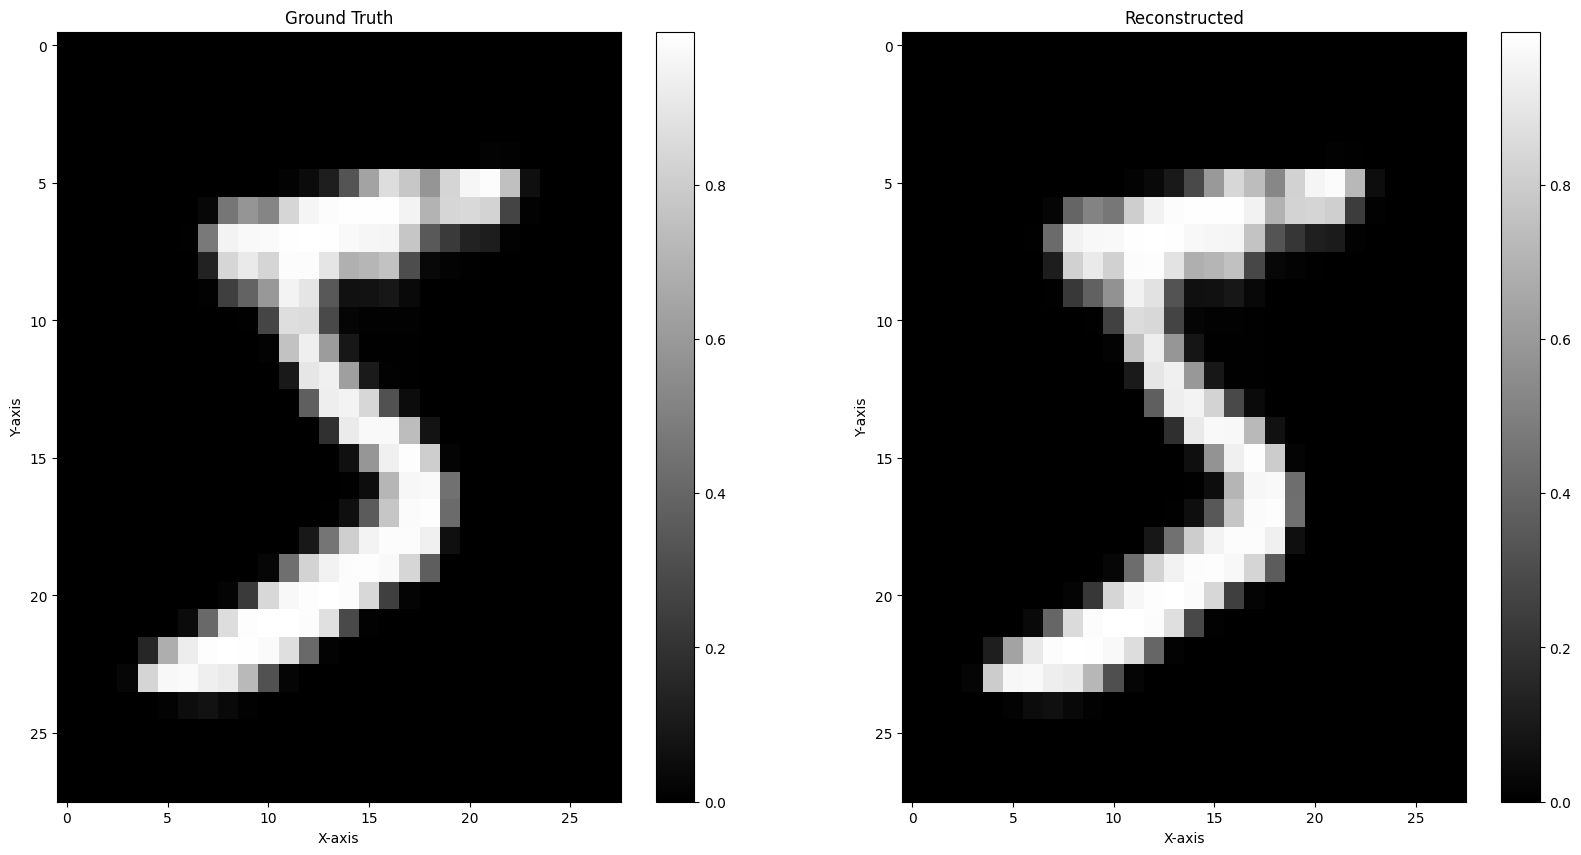

In [48]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import OrderedDict
from typing import List, Tuple, Union
from torch import nn
from animation.util import backtransform_weights, MinMaxTransform

# Assuming the following classes and functions are defined elsewhere:
# - INR
# - dataset_no_transform
# - ae_trained
# - dataset_flatten



# Configuration
inr_kwargs = {"n_layers": 3, "in_dim": 2, "up_scale": 16}
image_size = (28, 28)
idx = 0
# Get dataset elements
original_dict = dataset_no_transform[idx][0]

model = RegressionTransformer(model_config)
model.load_state_dict(torch.load("./models/ckpt.pt")["model"])


sample = dataset[idx][0]
X, Y = (sample[:model_config.block_size].unsqueeze(-1).unsqueeze(0), sample[1: 1 + model_config.block_size].unsqueeze(-1).unsqueeze(0))


pred, _ = model(X, Y)

minmax_transformer = MinMaxTransform(min_value=min_ours, max_value=max_ours)
dataset_ele_flattened = minmax_transformer.reverse(torch.cat((X[0][0].unsqueeze(0), pred[0])).unsqueeze(0))

# Backtransform weights
reconstructed_dict = backtransform_weights(dataset_ele_flattened, original_dict)

from animation.util import reconstruct_image
from networks.mlp_models import MLP3D


model_config_nef = {
        "out_size": 1,
        "hidden_neurons": [16, 16],
        "use_leaky_relu": False,
        "output_type": "logits",
        "input_dims": 2,
        "multires": 4,
    }

model = MLP3D(**model_config_nef)
model.load_state_dict(reconstructed_dict)
reconstructed_tensor = reconstruct_image(model)
model.load_state_dict(original_dict)
ground_truth_tensor = reconstruct_image(model)

# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(ground_truth_tensor, cmap='gray', aspect='auto')
axes[0].set_title('Ground Truth')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')

axes[1].imshow(reconstructed_tensor, cmap='gray', aspect='auto')
axes[1].set_title('Reconstructed')
axes[1].set_xlabel('X-axis')
axes[1].set_ylabel('Y-axis')

plt.colorbar(axes[0].imshow(ground_truth_tensor, cmap='gray', aspect='auto'), ax=axes[0])
plt.colorbar(axes[1].imshow(reconstructed_tensor, cmap='gray', aspect='auto'), ax=axes[1])
plt.show()